# Graph Neural Network (GNN) - Node Classification pada Dataset Cora

Notebook ini mengimplementasikan Graph Convolutional Network (GCN) untuk tugas node classification menggunakan dataset Cora.

## Fitur:
- PyTorch Geometric untuk GNN
- Early Stopping & Model Checkpoint
- Learning Rate Scheduler
- Visualisasi Node Embedding dengan t-SNE
- Confusion Matrix & Classification Report

## 1. Persiapan dan Instalasi Dependencies

In [4]:
# Import library utama
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# PyTorch Geometric
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

# Untuk visualisasi dan evaluasi
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cpu
PyTorch Geometric version: 2.7.0
CUDA available: False


In [5]:
# Tentukan device: CUDA jika tersedia, jika tidak gunakan CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")

Using device: cpu


## 2. Load Dataset Cora

In [6]:
# Load dataset Cora dari PyTorch Geometric
# Dataset akan disimpan di folder ../dataset
dataset_path = os.path.join('..', 'dataset', 'Cora')
dataset = Planetoid(root=dataset_path, name='Cora', transform=NormalizeFeatures())

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Processing...
Processing...


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [7]:
# Ambil data graph (Cora adalah single graph)
data = dataset[0].to(device)

print("\n=== Dataset Information ===")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features per node: {data.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"\nAverage node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

print("\n=== Data Splits ===")
print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

print("\n=== Class Distribution ===")
for i in range(dataset.num_classes):
    count = (data.y == i).sum().item()
    print(f"Class {i}: {count} nodes")


=== Dataset Information ===
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7

Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True

=== Data Splits ===
Training nodes: 140
Validation nodes: 500
Test nodes: 1000

=== Class Distribution ===
Class 0: 351 nodes
Class 1: 217 nodes
Class 2: 418 nodes
Class 3: 818 nodes
Class 4: 426 nodes
Class 5: 298 nodes
Class 6: 180 nodes


## 3. Bangun Arsitektur Model GCN (Graph Convolutional Network)

In [8]:
class GCN(torch.nn.Module):
    """
    Graph Convolutional Network (GCN) untuk Node Classification
    
    Arsitektur:
    - Layer 1: GCNConv(in_channels -> hidden_channels) + ReLU + Dropout
    - Layer 2: GCNConv(hidden_channels -> out_channels) + LogSoftmax
    
    Args:
        in_channels (int): Jumlah fitur input per node
        hidden_channels (int): Jumlah unit di hidden layer
        out_channels (int): Jumlah kelas output
        dropout (float): Dropout rate untuk regularisasi
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        
        # Layer 1: Input -> Hidden
        self.conv1 = GCNConv(in_channels, hidden_channels)
        
        # Layer 2: Hidden -> Output
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        # Dropout untuk regularisasi
        self.dropout = Dropout(p=dropout)
        
    def forward(self, x, edge_index, return_embedding=False):
        """
        Forward pass melalui GCN
        
        Args:
            x: Node feature matrix [num_nodes, in_channels]
            edge_index: Graph connectivity [2, num_edges]
            return_embedding: Jika True, return embedding dari layer 1
        
        Returns:
            log_softmax output atau embedding (jika return_embedding=True)
        """
        # Layer 1: GCNConv -> ReLU -> Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        embedding = x  # Simpan embedding untuk visualisasi
        x = self.dropout(x)
        
        # Jika diminta return embedding (untuk visualisasi)
        if return_embedding:
            return embedding
        
        # Layer 2: GCNConv -> LogSoftmax
        x = self.conv2(x, edge_index)
        output = F.log_softmax(x, dim=1)
        
        return output
    
    def reset_parameters(self):
        """Reset semua parameter ke nilai awal"""
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

# Inisialisasi model
hidden_channels = 16
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
    dropout=0.5
).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
  (dropout): Dropout(p=0.5, inplace=False)
)

Total parameters: 23,063
Trainable parameters: 23,063


## 4. Inisialisasi Optimizer, Loss Function, dan Scheduler

In [9]:
# Optimizer: Adam dengan learning rate dan weight decay
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Loss function: Negative Log Likelihood Loss (cocok dengan log_softmax)
criterion = torch.nn.NLLLoss()

# Scheduler: StepLR untuk menurunkan learning rate secara bertahap
# Learning rate akan dikali gamma setiap step_size epoch
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

print("Optimizer:", optimizer)
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"Weight Decay: {optimizer.param_groups[0]['weight_decay']}")
print("\nScheduler:", scheduler)
print(f"Step Size: {scheduler.step_size}")
print(f"Gamma: {scheduler.gamma}")

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0005
)
Initial Learning Rate: 0.01
Weight Decay: 0.0005

Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x000001E375F46C30>
Step Size: 50
Gamma: 0.5


## 5. Fungsi Training dan Evaluasi dengan Early Stopping

In [10]:
def train():
    """
    Fungsi training untuk satu epoch
    
    Returns:
        loss (float): Training loss
    """
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    out = model(data.x, data.edge_index)
    
    # Hitung loss hanya pada training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    return loss.item()


def evaluate(mask):
    """
    Fungsi evaluasi untuk menghitung akurasi
    
    Args:
        mask: Boolean mask untuk memilih nodes (train/val/test)
    
    Returns:
        accuracy (float): Akurasi prediksi
    """
    model.eval()
    
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out[mask].argmax(dim=1)
        correct = (pred == data.y[mask]).sum()
        accuracy = int(correct) / int(mask.sum())
    
    return accuracy


def save_checkpoint(model, optimizer, epoch, val_acc, path='../model/best_gcn_model.pth'):
    """
    Simpan model checkpoint
    
    Args:
        model: Model yang akan disimpan
        optimizer: Optimizer state
        epoch: Epoch saat ini
        val_acc: Validation accuracy
        path: Path untuk menyimpan model
    """
    # Buat folder jika belum ada
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'hidden_channels': hidden_channels,
        'in_channels': dataset.num_features,
        'out_channels': dataset.num_classes
    }, path)
    print(f"Model checkpoint saved at epoch {epoch} with val_acc: {val_acc:.4f}")


def load_checkpoint(model, optimizer, path='../model/best_gcn_model.pth'):
    """
    Load model checkpoint
    
    Args:
        model: Model untuk load state
        optimizer: Optimizer untuk load state
        path: Path ke checkpoint file
    
    Returns:
        epoch, val_acc
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_acc = checkpoint['val_acc']
    
    print(f"Model loaded from epoch {epoch} with val_acc: {val_acc:.4f}")
    return epoch, val_acc

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


## 6. Training Loop dengan Early Stopping dan Model Checkpoint

In [11]:
# Hyperparameters
max_epochs = 200
patience = 10  # Early stopping patience
log_interval = 10  # Print log setiap 10 epoch

# Tracking variables
best_val_acc = 0.0
patience_counter = 0
train_losses = []
val_accuracies = []
learning_rates = []

print("=" * 70)
print("Starting Training...")
print("=" * 70)
print(f"Max Epochs: {max_epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"Initial Learning Rate: {optimizer.param_groups[0]['lr']}")
print("=" * 70)

# Training loop
for epoch in range(1, max_epochs + 1):
    # Training
    loss = train()
    
    # Evaluation
    train_acc = evaluate(data.train_mask)
    val_acc = evaluate(data.val_mask)
    
    # Simpan metrics untuk plotting
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Update learning rate scheduler
    scheduler.step()
    
    # Check jika validation accuracy meningkat
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Simpan model terbaik
        save_checkpoint(model, optimizer, epoch, val_acc)
    else:
        patience_counter += 1
    
    # Print log setiap log_interval epoch
    if epoch % log_interval == 0 or epoch == 1:
        print(f"Epoch: {epoch:03d} | "
              f"Loss: {loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Best Val Acc: {best_val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Patience: {patience_counter}/{patience}")
    
    # Early stopping
    if patience_counter >= patience:
        print("\n" + "=" * 70)
        print(f"Early stopping triggered at epoch {epoch}")
        print(f"Best validation accuracy: {best_val_acc:.4f}")
        print("=" * 70)
        break

print("\n" + "=" * 70)
print("Training completed!")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("=" * 70)

Starting Training...
Max Epochs: 200
Early Stopping Patience: 10
Initial Learning Rate: 0.01
Model checkpoint saved at epoch 1 with val_acc: 0.1440
Epoch: 001 | Loss: 1.9459 | Train Acc: 0.3214 | Val Acc: 0.1440 | Best Val Acc: 0.1440 | LR: 0.010000 | Patience: 0/10
Model checkpoint saved at epoch 2 with val_acc: 0.2720
Model checkpoint saved at epoch 1 with val_acc: 0.1440
Epoch: 001 | Loss: 1.9459 | Train Acc: 0.3214 | Val Acc: 0.1440 | Best Val Acc: 0.1440 | LR: 0.010000 | Patience: 0/10
Model checkpoint saved at epoch 2 with val_acc: 0.2720
Model checkpoint saved at epoch 3 with val_acc: 0.2940
Model checkpoint saved at epoch 4 with val_acc: 0.3260
Model checkpoint saved at epoch 3 with val_acc: 0.2940
Model checkpoint saved at epoch 4 with val_acc: 0.3260
Epoch: 010 | Loss: 1.8570 | Train Acc: 0.4643 | Val Acc: 0.2260 | Best Val Acc: 0.3260 | LR: 0.010000 | Patience: 6/10
Epoch: 010 | Loss: 1.8570 | Train Acc: 0.4643 | Val Acc: 0.2260 | Best Val Acc: 0.3260 | LR: 0.010000 | Patien

## 7. Visualisasi Training Progress

Training progress plot saved as 'training_progress.png'


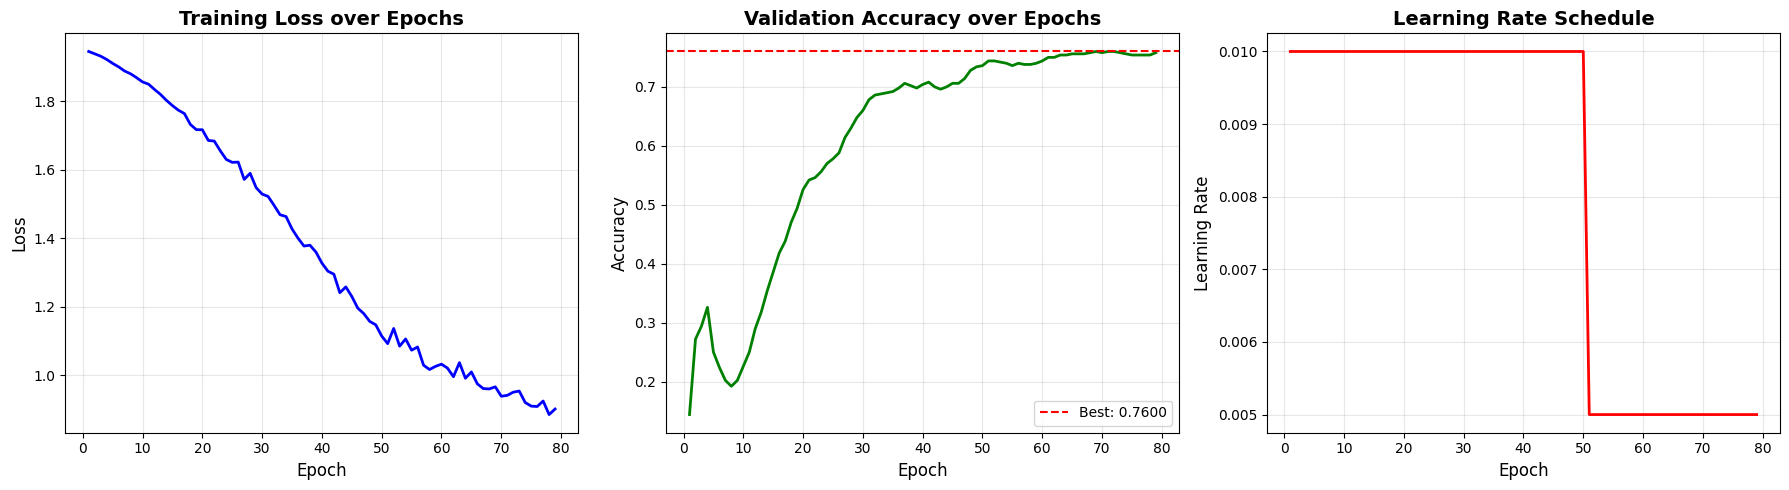

In [12]:
# Plot training progress
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training Loss
axes[0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
axes[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, 'g-', linewidth=2)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best: {best_val_acc:.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning Rate
axes[2].plot(range(1, len(learning_rates) + 1), learning_rates, 'r-', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../model/training_progress.png', dpi=300, bbox_inches='tight')
print("Training progress plot saved as 'training_progress.png'")
plt.show()

## 8. Evaluasi Model Terbaik pada Test Set

In [13]:
# Load model terbaik
checkpoint_path = '../model/best_gcn_model.pth'
load_checkpoint(model, optimizer, checkpoint_path)

# Evaluasi pada semua splits
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

# Hitung akurasi untuk setiap split
train_acc = evaluate(data.train_mask)
val_acc = evaluate(data.val_mask)
test_acc = evaluate(data.test_mask)

print("\n" + "=" * 70)
print("FINAL MODEL EVALUATION")
print("=" * 70)
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
print("=" * 70)

Model loaded from epoch 69 with val_acc: 0.7600

FINAL MODEL EVALUATION
Training Accuracy:   0.9857 (98.57%)
Validation Accuracy: 0.7600 (76.00%)
Test Accuracy:       0.7620 (76.20%)


## 9. Confusion Matrix dan Classification Report

Confusion matrix saved as 'confusion_matrix.png'


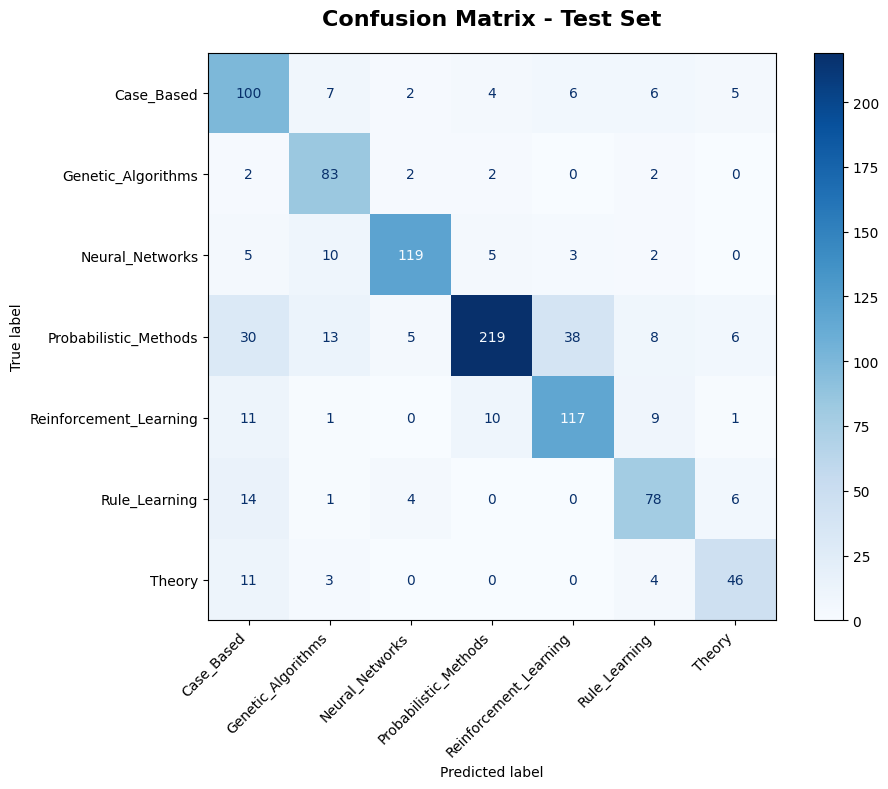


CLASSIFICATION REPORT - TEST SET
                        precision    recall  f1-score   support

            Case_Based     0.5780    0.7692    0.6601       130
    Genetic_Algorithms     0.7034    0.9121    0.7943        91
       Neural_Networks     0.9015    0.8264    0.8623       144
 Probabilistic_Methods     0.9125    0.6865    0.7835       319
Reinforcement_Learning     0.7134    0.7852    0.7476       149
         Rule_Learning     0.7156    0.7573    0.7358       103
                Theory     0.7188    0.7188    0.7188        64

              accuracy                         0.7620      1000
             macro avg     0.7490    0.7794    0.7575      1000
          weighted avg     0.7861    0.7620    0.7654      1000



In [14]:
# Ambil prediksi dan ground truth untuk test set
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Class names untuk Cora dataset
class_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
               'Probabilistic_Methods', 'Reinforcement_Learning', 
               'Rule_Learning', 'Theory']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../model/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT - TEST SET")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
print("=" * 70)

## 10. Visualisasi Node Embedding dengan t-SNE

In [15]:
# Ambil embedding dari layer pertama GCN
model.eval()
with torch.no_grad():
    # return_embedding=True untuk mendapatkan output dari layer 1
    embeddings = model(data.x, data.edge_index, return_embedding=True)
    embeddings = embeddings.cpu().numpy()

# Labels untuk pewarnaan
labels = data.y.cpu().numpy()

print("Applying t-SNE for dimensionality reduction...")
print(f"Original embedding shape: {embeddings.shape}")

# t-SNE untuk reduksi dimensi ke 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

print(f"t-SNE embedding shape: {embeddings_2d.shape}")
print("t-SNE completed!")

Applying t-SNE for dimensionality reduction...
Original embedding shape: (2708, 16)
t-SNE embedding shape: (2708, 2)
t-SNE completed!
t-SNE embedding shape: (2708, 2)
t-SNE completed!



t-SNE visualization saved as 'tsne_visualization.png'


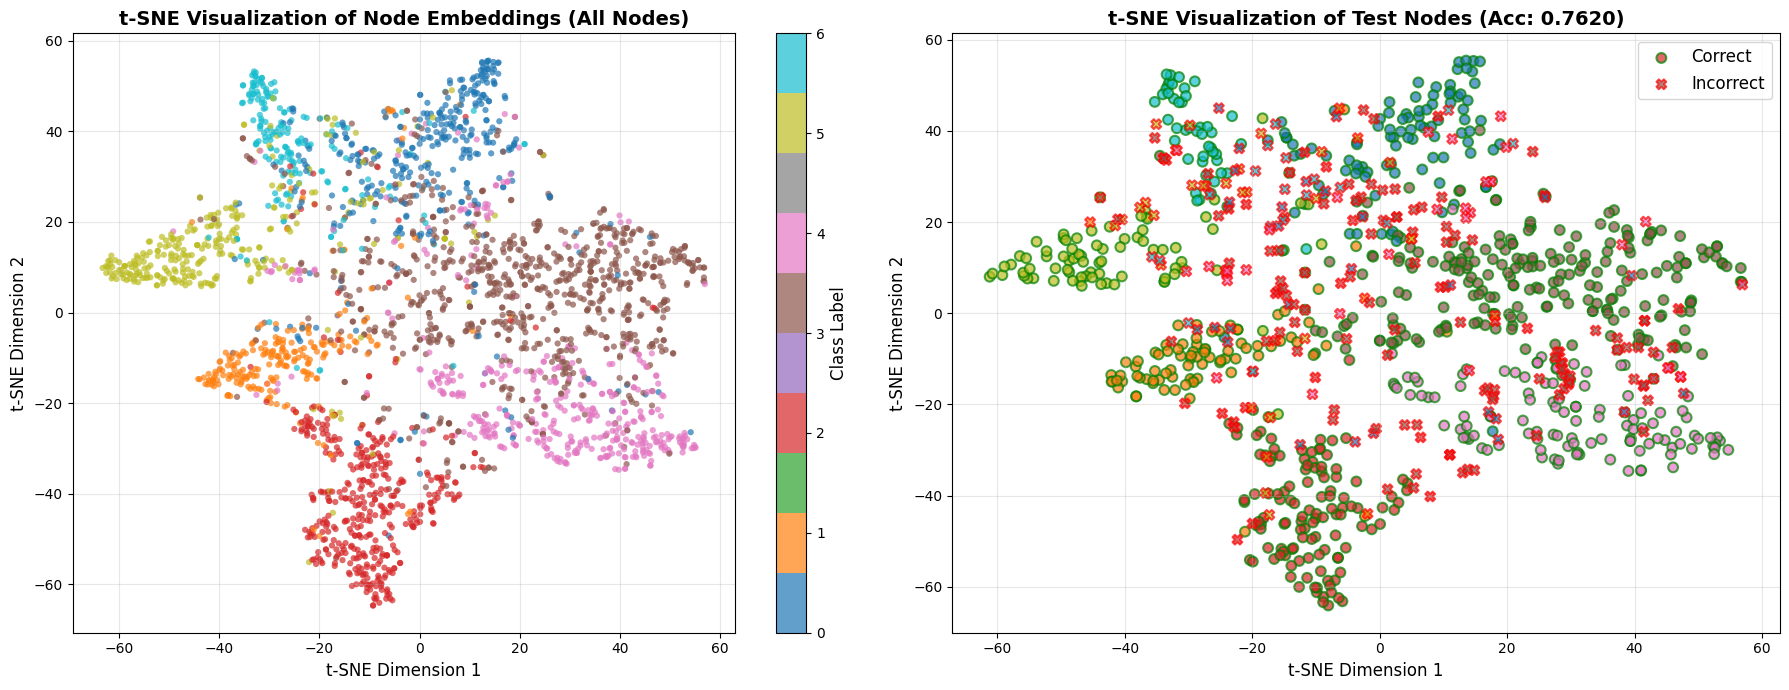

In [16]:
# Visualisasi t-SNE dengan pewarnaan berdasarkan kelas
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Semua nodes
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=labels, cmap='tab10', s=20, alpha=0.7, edgecolors='none')
axes[0].set_title('t-SNE Visualization of Node Embeddings (All Nodes)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=12)
cbar1 = plt.colorbar(scatter, ax=axes[0])
cbar1.set_label('Class Label', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Hanya test nodes dengan prediksi
test_embeddings = embeddings_2d[data.test_mask.cpu().numpy()]
test_labels = labels[data.test_mask.cpu().numpy()]
test_pred = pred[data.test_mask].cpu().numpy()

# Warna berbeda untuk correct vs incorrect predictions
correct_mask = test_labels == test_pred
incorrect_mask = ~correct_mask

axes[1].scatter(test_embeddings[correct_mask, 0], test_embeddings[correct_mask, 1],
               c=test_labels[correct_mask], cmap='tab10', s=50, alpha=0.7, 
               edgecolors='green', linewidths=1.5, label='Correct')
axes[1].scatter(test_embeddings[incorrect_mask, 0], test_embeddings[incorrect_mask, 1],
               c=test_labels[incorrect_mask], cmap='tab10', s=50, alpha=0.7, 
               edgecolors='red', linewidths=1.5, marker='X', label='Incorrect')

axes[1].set_title(f't-SNE Visualization of Test Nodes (Acc: {test_acc:.4f})', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=12)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../model/tsne_visualization.png', dpi=300, bbox_inches='tight')
print("\nt-SNE visualization saved as 'tsne_visualization.png'")
plt.show()

## 11. Visualisasi Detail per Kelas

Per-class t-SNE visualization saved as 'tsne_per_class.png'


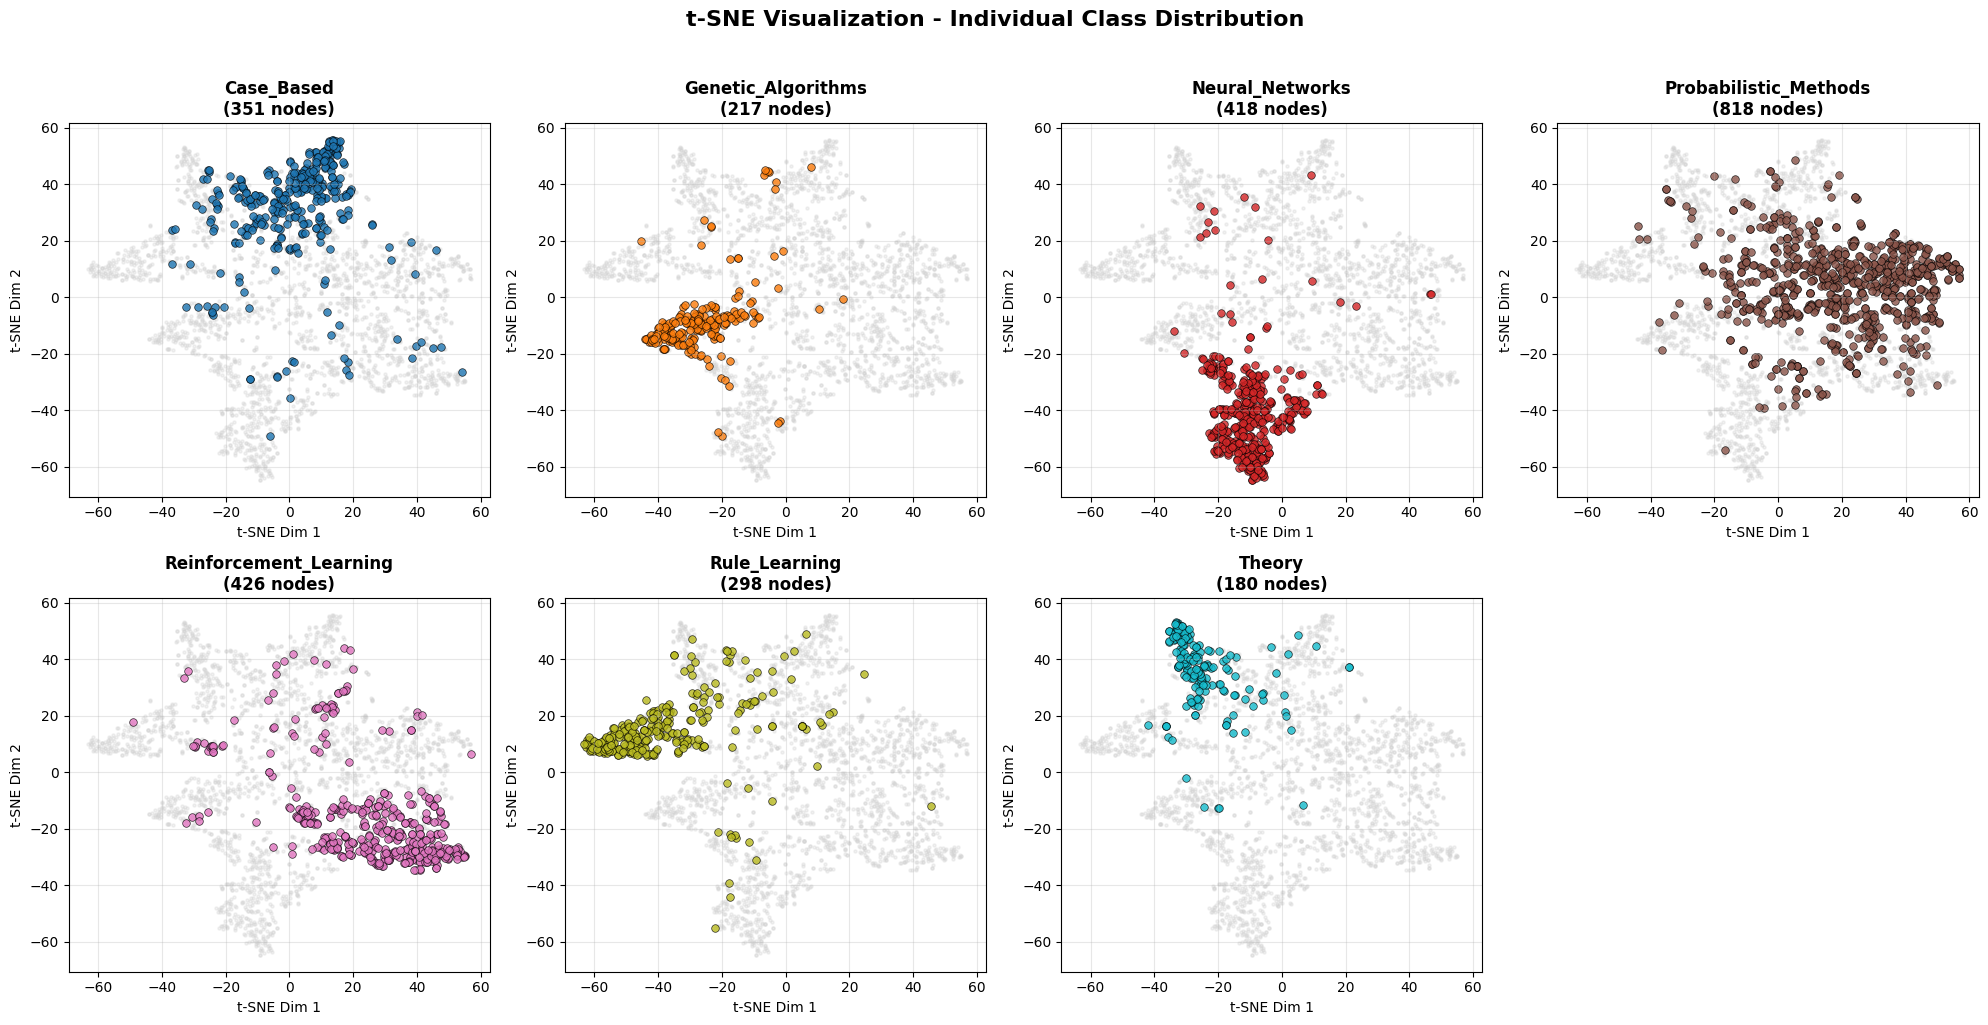

In [17]:
# Visualisasi distribusi per kelas dengan subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

for idx, (class_name, color) in enumerate(zip(class_names, colors)):
    # Mask untuk kelas ini
    class_mask = labels == idx
    
    # Plot semua nodes dengan warna abu-abu
    axes[idx].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c='lightgray', s=5, alpha=0.3)
    
    # Highlight nodes dari kelas ini
    axes[idx].scatter(embeddings_2d[class_mask, 0], embeddings_2d[class_mask, 1],
                     c=[color], s=30, alpha=0.8, edgecolors='black', linewidths=0.5)
    
    axes[idx].set_title(f'{class_name}\n({class_mask.sum()} nodes)', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Dim 1', fontsize=10)
    axes[idx].set_ylabel('t-SNE Dim 2', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle('t-SNE Visualization - Individual Class Distribution', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../model/tsne_per_class.png', dpi=300, bbox_inches='tight')
print("Per-class t-SNE visualization saved as 'tsne_per_class.png'")
plt.show()

## 12. Summary dan Ringkasan Hasil

In [18]:
print("\n" + "="*80)
print(" " * 20 + "GNN NODE CLASSIFICATION - FINAL SUMMARY")
print("="*80)

print("\n📊 DATASET INFORMATION:")
print(f"  • Dataset: Cora")
print(f"  • Total Nodes: {data.num_nodes:,}")
print(f"  • Total Edges: {data.num_edges:,}")
print(f"  • Node Features: {data.num_features}")
print(f"  • Number of Classes: {dataset.num_classes}")
print(f"  • Train/Val/Test Split: {data.train_mask.sum()}/{data.val_mask.sum()}/{data.test_mask.sum()}")

print("\n🏗️  MODEL ARCHITECTURE:")
print(f"  • Model Type: Graph Convolutional Network (GCN)")
print(f"  • Hidden Channels: {hidden_channels}")
print(f"  • Dropout Rate: 0.5")
print(f"  • Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n⚙️  TRAINING CONFIGURATION:")
print(f"  • Optimizer: Adam (lr=0.01, weight_decay=5e-4)")
print(f"  • Scheduler: StepLR (step_size=50, gamma=0.5)")
print(f"  • Loss Function: NLLLoss")
print(f"  • Max Epochs: {max_epochs}")
print(f"  • Early Stopping Patience: {patience}")
print(f"  • Actual Training Epochs: {len(train_losses)}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  • Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  • Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  • Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")

print("\n💾 SAVED FILES:")
print(f"  • Model Checkpoint: ../model/best_gcn_model.pth")
print(f"  • Training Progress Plot: ../model/training_progress.png")
print(f"  • Confusion Matrix: ../model/confusion_matrix.png")
print(f"  • t-SNE Visualization: ../model/tsne_visualization.png")
print(f"  • Per-Class t-SNE: ../model/tsne_per_class.png")

print("\n✅ PROJECT STATUS: COMPLETED SUCCESSFULLY!")
print("="*80 + "\n")


                    GNN NODE CLASSIFICATION - FINAL SUMMARY

📊 DATASET INFORMATION:
  • Dataset: Cora
  • Total Nodes: 2,708
  • Total Edges: 10,556
  • Node Features: 1433
  • Number of Classes: 7
  • Train/Val/Test Split: 140/500/1000

🏗️  MODEL ARCHITECTURE:
  • Model Type: Graph Convolutional Network (GCN)
  • Hidden Channels: 16
  • Dropout Rate: 0.5
  • Total Parameters: 23,063

⚙️  TRAINING CONFIGURATION:
  • Optimizer: Adam (lr=0.01, weight_decay=5e-4)
  • Scheduler: StepLR (step_size=50, gamma=0.5)
  • Loss Function: NLLLoss
  • Max Epochs: 200
  • Early Stopping Patience: 10
  • Actual Training Epochs: 79

🎯 MODEL PERFORMANCE:
  • Training Accuracy:   0.9857 (98.57%)
  • Validation Accuracy: 0.7600 (76.00%)
  • Test Accuracy:       0.7620 (76.20%)

💾 SAVED FILES:
  • Model Checkpoint: ../model/best_gcn_model.pth
  • Training Progress Plot: ../model/training_progress.png
  • Confusion Matrix: ../model/confusion_matrix.png
  • t-SNE Visualization: ../model/tsne_visualization.p

## 13. (Opsional) Cara Menggunakan Model untuk Prediksi Baru

In [19]:
"""
Contoh penggunaan model untuk prediksi pada node tertentu
"""

# Fungsi untuk prediksi node tertentu
def predict_node(model, data, node_idx):
    """
    Prediksi kelas untuk node tertentu
    
    Args:
        model: Model GCN yang sudah dilatih
        data: Graph data
        node_idx: Index node yang ingin diprediksi
    
    Returns:
        predicted_class, confidence, true_class
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred_prob = torch.exp(out[node_idx])  # Convert log_softmax to probability
        pred_class = out[node_idx].argmax().item()
        confidence = pred_prob[pred_class].item()
        true_class = data.y[node_idx].item()
    
    return pred_class, confidence, true_class


# Contoh: Prediksi 5 node random dari test set
print("="*70)
print("SAMPLE PREDICTIONS ON TEST NODES")
print("="*70)

test_indices = torch.where(data.test_mask)[0]
sample_indices = test_indices[torch.randperm(len(test_indices))[:5]]

for i, node_idx in enumerate(sample_indices, 1):
    pred_class, confidence, true_class = predict_node(model, data, node_idx)
    
    is_correct = "✓" if pred_class == true_class else "✗"
    
    print(f"\n{i}. Node {node_idx.item()}:")
    print(f"   Predicted: {class_names[pred_class]} (confidence: {confidence:.4f})")
    print(f"   True Label: {class_names[true_class]}")
    print(f"   Status: {is_correct} {'Correct' if pred_class == true_class else 'Incorrect'}")

print("\n" + "="*70)

SAMPLE PREDICTIONS ON TEST NODES

1. Node 1915:
   Predicted: Theory (confidence: 0.2397)
   True Label: Theory
   Status: ✓ Correct

2. Node 2318:
   Predicted: Genetic_Algorithms (confidence: 0.2295)
   True Label: Genetic_Algorithms
   Status: ✓ Correct

3. Node 1840:
   Predicted: Case_Based (confidence: 0.1831)
   True Label: Rule_Learning
   Status: ✗ Incorrect

4. Node 1784:
   Predicted: Genetic_Algorithms (confidence: 0.2979)
   True Label: Genetic_Algorithms
   Status: ✓ Correct

5. Node 1866:
   Predicted: Probabilistic_Methods (confidence: 0.2572)
   True Label: Probabilistic_Methods
   Status: ✓ Correct



## 14. (Opsional) Cara Extend ke Arsitektur Lain (GAT, GraphSAGE)

Kode di bawah menunjukkan bagaimana mudahnya mengganti arsitektur GCN ke GAT atau GraphSAGE:

In [20]:
"""
Contoh implementasi GAT (Graph Attention Network) dan GraphSAGE
Uncomment untuk mencoba arsitektur lain
"""

# from torch_geometric.nn import GATConv, SAGEConv

# # GAT Model
# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
#         super(GAT, self).__init__()
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
#         self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, 
#                             concat=False, dropout=dropout)
#         self.dropout = Dropout(p=dropout)
#     
#     def forward(self, x, edge_index, return_embedding=False):
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         embedding = x
#         x = self.dropout(x)
#         
#         if return_embedding:
#             return embedding
#         
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)


# # GraphSAGE Model
# class GraphSAGE(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
#         super(GraphSAGE, self).__init__()
#         self.conv1 = SAGEConv(in_channels, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, out_channels)
#         self.dropout = Dropout(p=dropout)
#     
#     def forward(self, x, edge_index, return_embedding=False):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         embedding = x
#         x = self.dropout(x)
#         
#         if return_embedding:
#             return embedding
#         
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)


# # Untuk menggunakan model lain, cukup ganti inisialisasi:
# # model = GAT(dataset.num_features, 8, dataset.num_classes).to(device)
# # atau
# # model = GraphSAGE(dataset.num_features, 16, dataset.num_classes).to(device)

print("Template untuk GAT dan GraphSAGE tersedia!")
print("Uncomment kode di atas untuk mencoba arsitektur berbeda.")

Template untuk GAT dan GraphSAGE tersedia!
Uncomment kode di atas untuk mencoba arsitektur berbeda.
